In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import json
import torch.nn as nn
# import torchvision
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
img = Image.open('./test.JPEG')
img = img.convert('RGB')

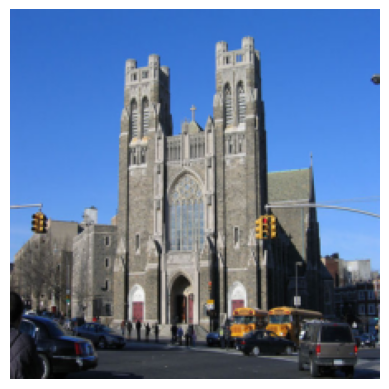

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
img = transform(img)
img_hwc = img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
img = img.unsqueeze(dim=0)

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
net = resnet50(num_classes=1000, pretrained=True)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), net)
model.eval()

/home/rj/.conda/envs/fai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rj/.conda/envs/fai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [6]:
model.eval()
prob = model(img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Natural Image:", target_class[1])

Natural Image: church


# Q1: PGD attack
According to the PPT or the original paper, implement the Projected Gradient Desent (PGD) attack.
https://arxiv.org/abs/1706.06083

In [45]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

def attack_pgd(model, X, y, epsilon=8/255, alpha=2/255, attack_iters=10, restarts=1, lower_limit=torch.tensor([0]), upper_limit=torch.tensor([1])):
    """
    model: Model to attack.
    X: Input image
    y: Class of input image
    epsilon: Budget of PGD attack
    alpha: Step size for PGD attack
    attack_iters: Iterations for PGD attack
    restarts: Restarts for PGD attack
    lower limits: Lower limits for Input Images
    upper limits: Upper limits for Input Images
    """
    ###################################
    # write the code here
    ###################################
    # return max_delta
    # print(X.shape) # torch.Size([1, 3, 224, 224])
    device = X.device
    best_delta = torch.zeros_like(X, device=device)
    best_loss = -float('inf')

    # 确保上下限与X同设备
    lower_limit = lower_limit.to(device)
    upper_limit = upper_limit.to(device)

    for i in range(restarts):
        
        print(f'trail {i}:')
        # 初始化
        delta = torch.empty_like(X).uniform_(-epsilon, epsilon)
        delta = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True

        # 小步多次
        for iter in range(attack_iters):
            print(f'    iter {iter}')
            adv_X = X + delta

            output = model(adv_X)
            loss = torch.nn.functional.cross_entropy(output, y)
            
            # 清零梯度
            model.zero_grad() # 注意！！！！
            if delta.grad is not None:
                delta.grad.zero_()
            loss.backward()




            # 更新delta
            grad_sign = delta.grad.detach().sign()
            delta = delta.detach() + alpha * grad_sign
            delta = clamp(delta, torch.tensor([-epsilon]), torch.tensor([epsilon]))
            delta = clamp(delta, lower_limit - X, upper_limit - X)
            delta.requires_grad_(True)


        with torch.no_grad():
            adv_X = X + delta
            output = model(adv_X)
            cur_loss = torch.nn.functional.cross_entropy(output, y)
            if cur_loss > best_loss:
                best_delta = delta.detach()
                best_loss = cur_loss

    return best_delta


    

trail 0:
    iter 0
    iter 1


    iter 2
    iter 3
    iter 4
    iter 5
    iter 6
    iter 7
    iter 8
    iter 9


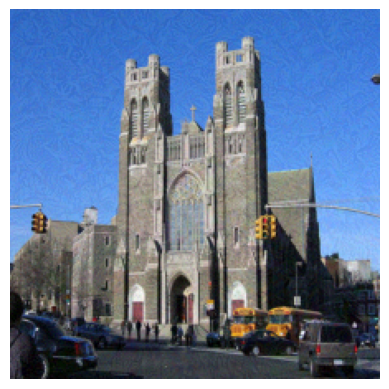

Adversarial Image: bell_cote


In [47]:
delta = attack_pgd(model,img,label.unsqueeze(dim=0))
adv_img = img+delta
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Adversarial Image:", target_class[1])

# Q2: C&W attack
According to the PPT shown in the class, implement the Carlini  Wagner (C&W) attack.
https://arxiv.org/pdf/1608.04644.pdf?source=post_page

In [ ]:
def attack_cw(model, X, y, targeted=False, cw_kappa=0, cw_iters=10000, cw_c=1e-4, binary_search_steps = 9 , cw_lr= 0.01):
    """
    model: Model to attack
    X: Input image
    y: Class of input image
    targeted: Whether to apply targeted attack
    cw_kappa: kappa for C&W attack
    cw_iters: iteration for the C&W attack
    cw_c: constants for C&W attack
    binary_search_steps: steps for binary search
    cw_lr: learning rate for optimizer
    """
    def arctanh(imgs):
        scaling = torch.clamp(imgs, max=1, min=-1)
        x = 0.999999 * scaling
        x = 2*x-1
        return 0.5*torch.log((1+x)/(1-x))

    def scaler(x_atanh):
        return ((torch.tanh(x_atanh))+1) * 0.5

    def _f(adv_imgs, labels):
        ###################################
        # write the code here
        ###################################
        # return loss
        pass
    model.eval()
    X = X.detach().clone()
    x_arctanh = arctanh(X)
    for _ in tqdm.tqdm(range(binary_search_steps)):
        delta = torch.zeros_like(X)
        delta.detach_()
        delta.requires_grad = True
        optimizer = torch.optim.Adam([delta], lr=cw_lr)
        prev_loss = 1e6
        for step in range(cw_iters):
            optimizer.zero_grad()
            adv_examples = scaler(x_arctanh + delta)
            ###################################
            # write the code here
            ###################################
            if step % (cw_iters // 10) == 0:
                if loss > prev_loss:
                    break
                prev_loss = loss
        adv_imgs = scaler(x_arctanh + delta).detach()
    return adv_imgs

In [ ]:
adv_imgs = attack_cw(model,img,label.unsqueeze(dim=0),cw_iters=10)
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Adversarial Image:", target_class[1])